In [17]:
# Gerekli kütüphaneleri import edelim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf

In [18]:
import os
from pathlib import Path

base_output = Path("outputs")

folders = [
    "no_aug/model", "no_aug/plots", "no_aug/reports",
    "aug/model", "aug/plots", "aug/reports"
]

for folder in folders:
    os.makedirs(base_output / folder, exist_ok=True)

print("✅ Output klasörleri hazır")


✅ Output klasörleri hazır


In [19]:
# Görüntü dosyalarının bulunduğu dizini belirleyin
image_dir = Path('Fish_Dataset')  # ← DOĞRU YOL

filepaths = list(image_dir.glob('**/*.png'))  # resimleri bul
labels = [p.parent.name for p in filepaths]  # klasör adından label al

image_df = pd.DataFrame({
    'Filepath': [str(p) for p in filepaths],
    'Label': labels
})

# GT ile bitenleri çıkarma
image_df = image_df[~image_df['Label'].str.endswith('GT')]

print("Toplam görüntü:", len(image_df))
image_df.head()

Toplam görüntü: 9000


Filepath            Label
0  Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...  Black Sea Sprat
1  Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...  Black Sea Sprat
2  Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...  Black Sea Sprat
3  Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...  Black Sea Sprat
4  Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...  Black Sea Sprat

In [20]:
# DataFrame'i karıştırın ve indeksi sıfırlayın
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Sonucu gösterin
image_df.head(3)

Filepath            Label
0  Fish_Dataset\Gilt-Head Bream\Gilt-Head Bream\0...  Gilt-Head Bream
1  Fish_Dataset\Gilt-Head Bream\Gilt-Head Bream\0...  Gilt-Head Bream
2                 Fish_Dataset\Trout\Trout\00571.png            Trout

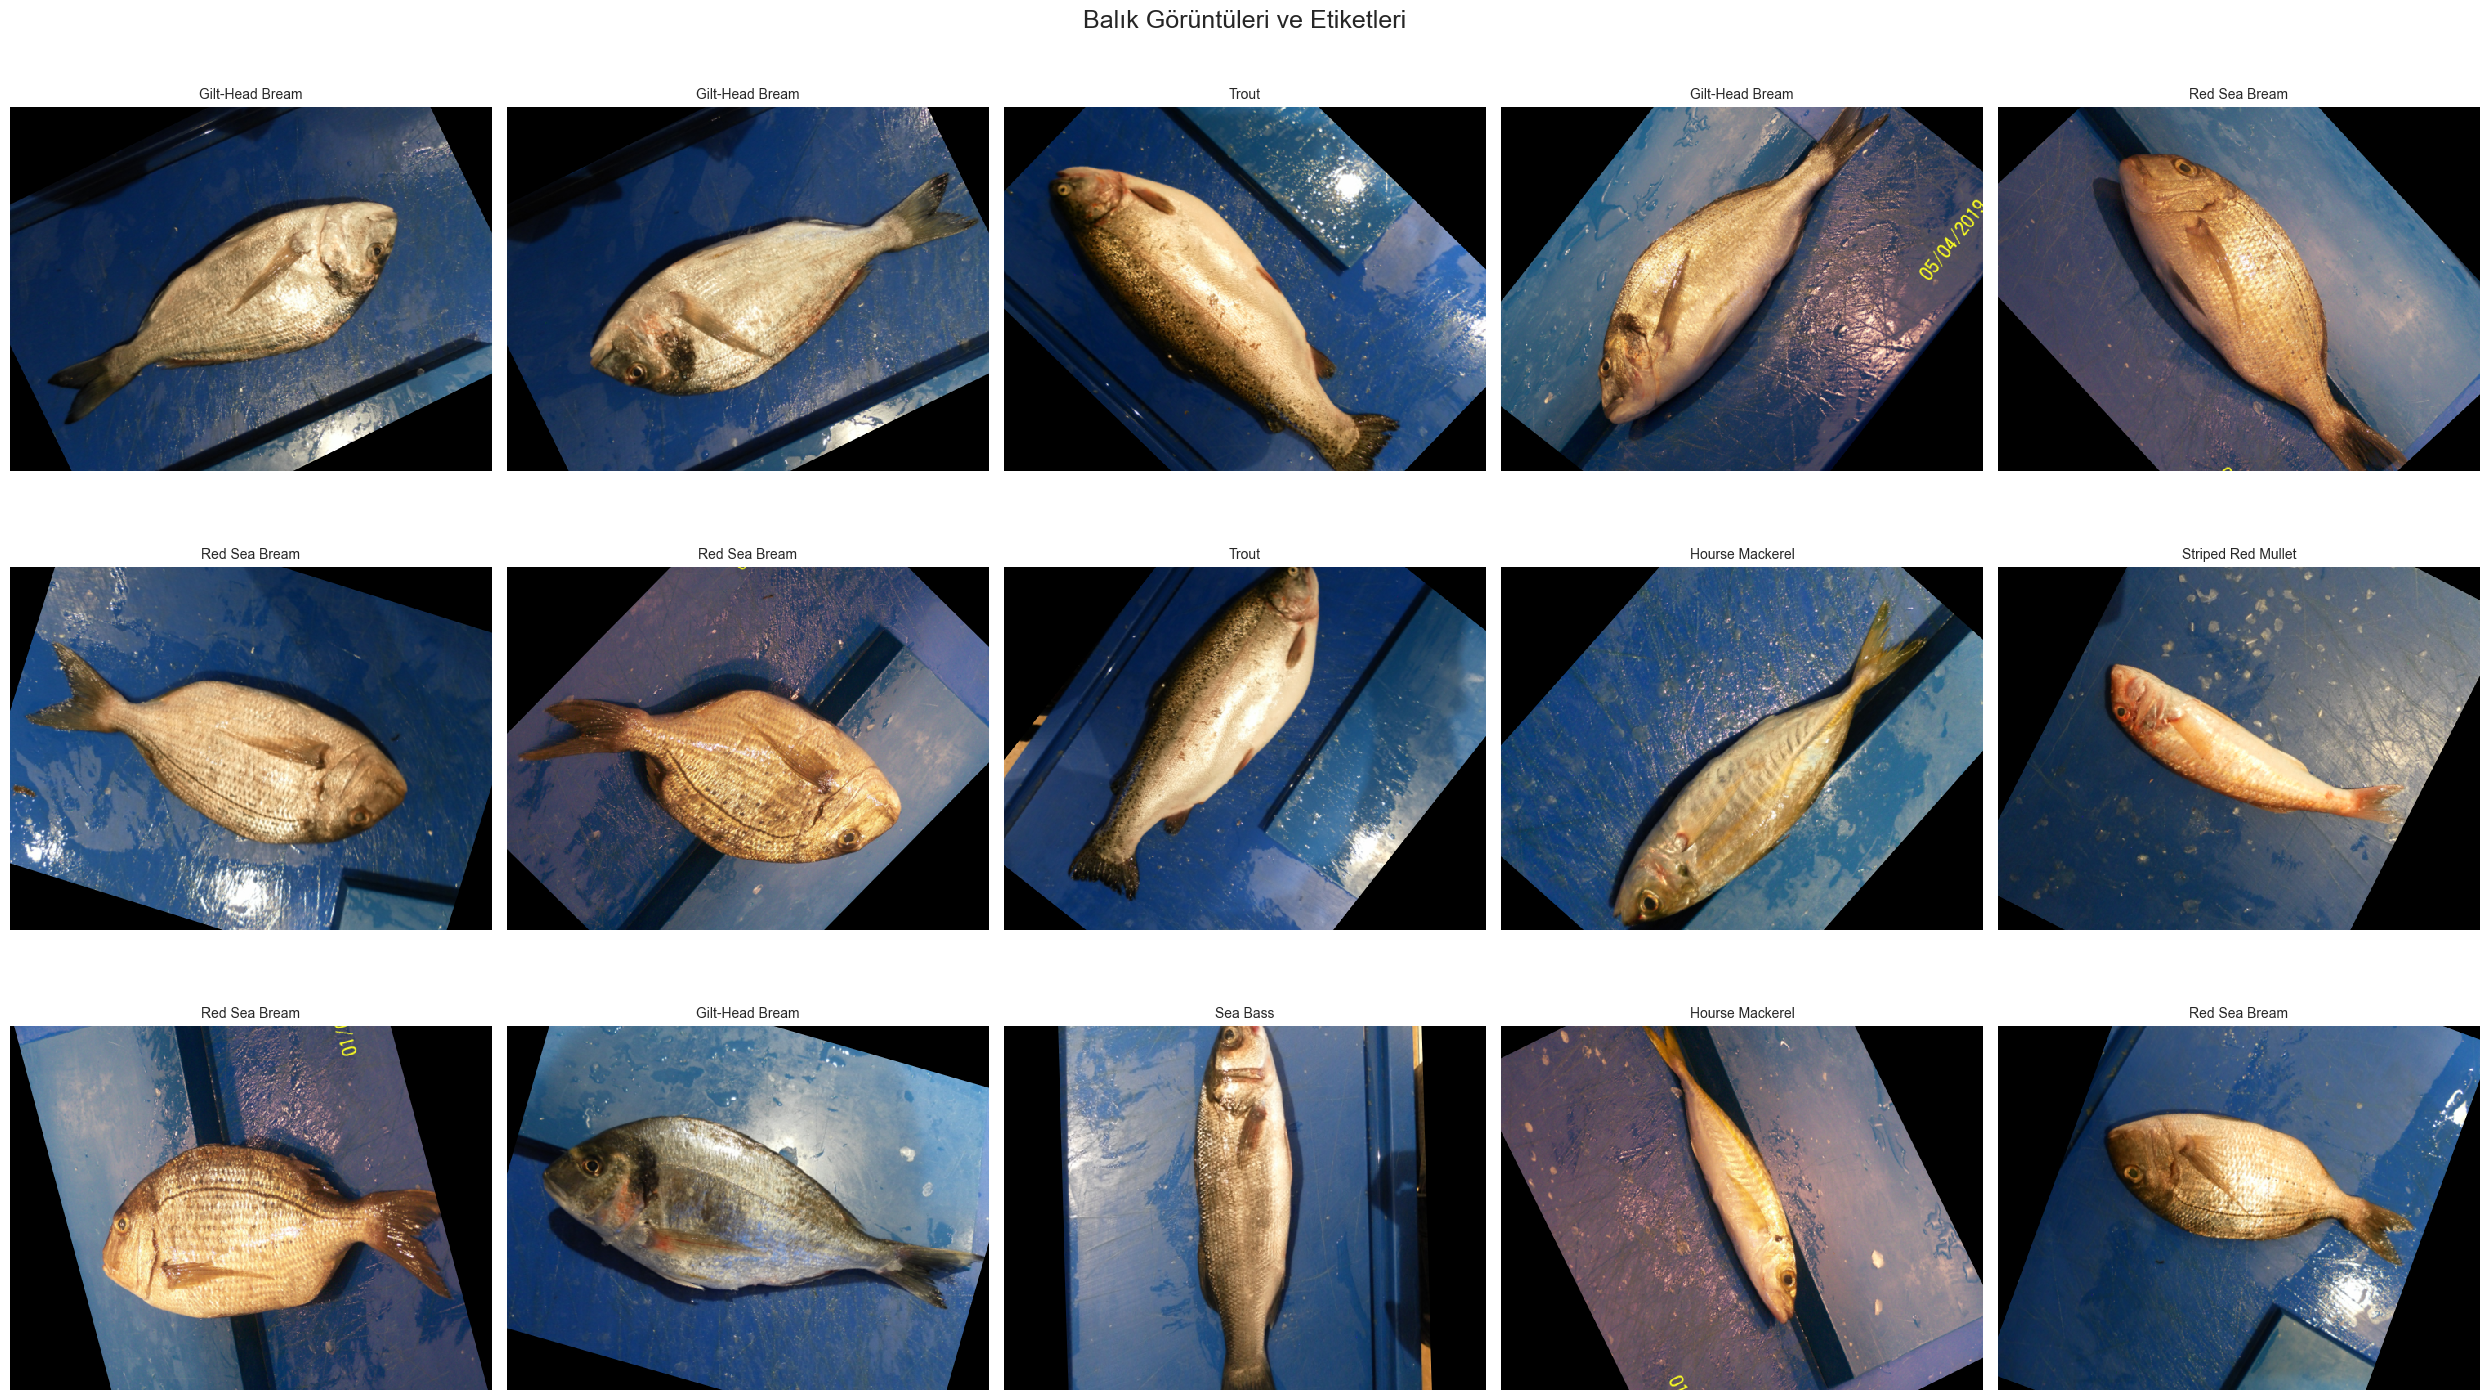

In [21]:
# Veri setinden etiketleriyle birlikte 20 resim görüntüleyin

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15))
for i, ax in enumerate(axes.flat[:15]):  # İlk 40 resim için
    image = plt.imread(image_df.Filepath.iloc[i])
    ax.imshow(image, interpolation='none')
    ax.set_title(image_df.Label.iloc[i], fontsize=10)
    ax.axis('off')

plt.suptitle('Balık Görüntüleri ve Etiketleri', fontsize=18)
plt.tight_layout()
plt.show()

In [22]:
train_df, test_df = train_test_split(
    image_df,
    train_size=0.8,   # %80 eğitim
    test_size=0.2,    # %20 test
    shuffle=True,
    random_state=1
)

In [23]:
len(train_df), len(test_df)

(7200, 1800)

In [28]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = train_df.Label.nunique()

In [29]:
no_aug_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

train_no_aug = no_aug_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)

val_no_aug = no_aug_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


In [30]:
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = False

model_no_aug = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model_no_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [31]:
callbacks_no_aug = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3),
    ModelCheckpoint(
        filepath="outputs/no_aug/model/best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [32]:
history_no_aug = model_no_aug.fit(
    train_no_aug,
    validation_data=val_no_aug,
    epochs=EPOCHS,
    callbacks=callbacks_no_aug
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9557 - loss: 0.1616 - val_accuracy: 0.9833 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 180s 997ms/step - accuracy: 0.9958 - loss: 0.0160 - val_accuracy: 0.9972 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 179s 997ms/step - accuracy: 0.9997 - loss: 0.0049 - val_accuracy: 0.9993 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 178s 989ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9986 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 179s 993ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9986 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 1.0000 - loss: 9.2192e-04 - val_accuracy: 0.9986 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 178s 991ms/step - accuracy

In [33]:
aug_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_aug = aug_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)

val_aug = aug_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


In [34]:
model_aug = tf.keras.models.clone_model(model_no_aug)
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [35]:
callbacks_aug = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3),
    ModelCheckpoint(
        filepath="outputs/aug/model/best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [36]:
history_aug = model_aug.fit(
    train_aug,
    validation_data=val_aug,
    epochs=EPOCHS,
    callbacks=callbacks_aug
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.1108 - loss: 2.1976 - val_accuracy: 0.1104 - val_loss: 2.1978 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.1075 - loss: 2.1973 - val_accuracy: 0.0917 - val_loss: 2.1977 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.1130 - loss: 2.1973 - val_accuracy: 0.1104 - val_loss: 2.1980 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.1097 - loss: 2.1973 - val_accuracy: 0.1104 - val_loss: 2.1981 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.1047 - loss: 2.1972 - val_accuracy: 0.1104 - val_loss: 2.1983 - learning_rate: 0.0010
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.1142 - loss: 2.1970 - val_accuracy: 0.1104 - val_loss: 2.1983 - learning_rate: 1.0000e-04
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.1142 - loss

In [37]:
test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_images = test_gen.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    shuffle=False
)

Found 1800 validated image filenames belonging to 9 classes.


In [39]:
import matplotlib.pyplot as plt

def compare_histories(history_no_aug, history_aug):
    epochs_no_aug = range(1, len(history_no_aug.history['val_accuracy']) + 1)
    epochs_aug = range(1, len(history_aug.history['val_accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # 🔵 Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_no_aug, history_no_aug.history['val_accuracy'], 'b-o', label='No Aug')
    plt.plot(epochs_aug, history_aug.history['val_accuracy'], 'g-o', label='Aug')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # 🔴 Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_no_aug, history_no_aug.history['val_loss'], 'r-o', label='No Aug')
    plt.plot(epochs_aug, history_aug.history['val_loss'], 'orange', marker='o', label='Aug')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


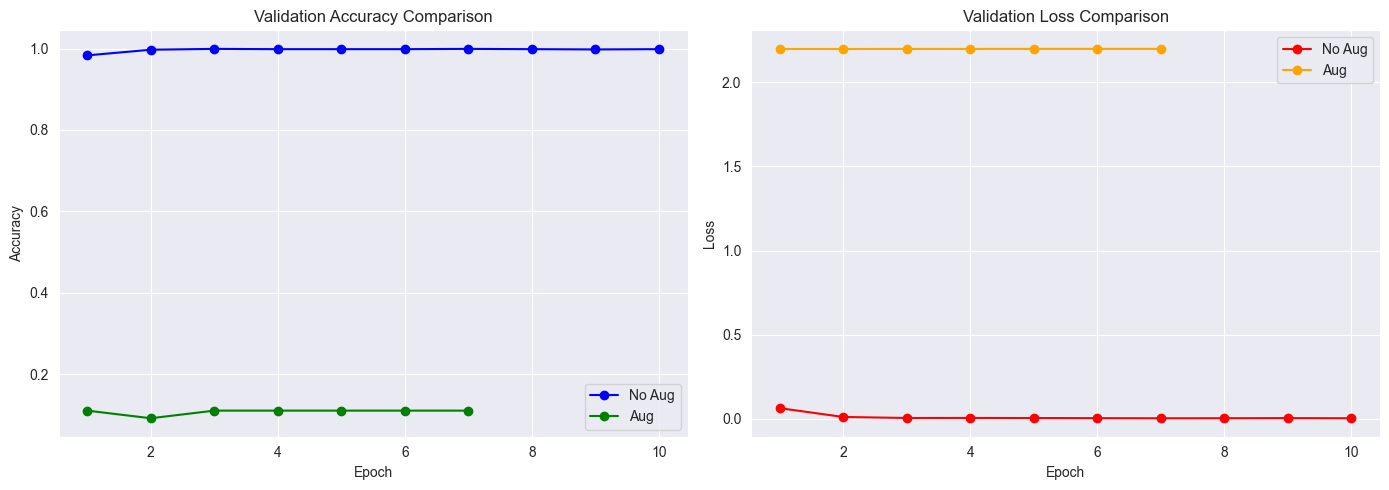

In [40]:
compare_histories(history_no_aug, history_aug)

In [38]:
def save_report(model, name):
    preds = model.predict(test_images)
    preds = np.argmax(preds, axis=1)

    labels = test_images.class_indices
    labels = dict((v,k) for k,v in labels.items())
    preds = [labels[i] for i in preds]

    report = classification_report(test_df.Label, preds)

    with open(f"outputs/{name}/reports/classification_report.txt", "w") as f:
        f.write(report)

    print(f"✅ {name} raporu kaydedildi")

save_report(model_no_aug, "no_aug")
save_report(model_aug, "aug")

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 889ms/step
✅ no_aug raporu kaydedildi
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 978ms/step
✅ aug raporu kaydedildi


C:\Users\USER\Desktop\DerinÖğrenme\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER\Desktop\DerinÖğrenme\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER\Desktop\DerinÖğrenme\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is